In [48]:
import cv2 
from matplotlib import pyplot as plt 
import numpy as np 
import imageio

In [49]:
def read_img(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    return img

In [50]:
# img_1 = read_img(r'C:\Users\richa\OneDrive\Documentos\Computer Vision\Computer-Vision-Course\Task_05\imagens\IMG_1.jpg')
# img_2 = read_img(r'C:\Users\richa\OneDrive\Documentos\Computer Vision\Computer-Vision-Course\Task_05\imagens\IMG_2.jpg')

trainImg = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg')
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)

queryImg = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg')
# Opencv defines the color channel in the order BGR. 
# Transform it to RGB to be compatible to matplotlib
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)


C:\Users\richa\AppData\Local\Temp\ipykernel_14884\3331632700.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  trainImg = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg')
C:\Users\richa\AppData\Local\Temp\ipykernel_14884\3331632700.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  queryImg = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg')


> # Calculate the points and matcher 

> SIFT algorithm

In [51]:
def show_img(img):
    plt.figure(figsize = (10,6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [52]:
def matching_sift(img1, img2,n_features, edgeThreshold):
    # Starting the sift algorithm
    sift = cv2.xfeatures2d.SIFT_create(nfeatures =n_features, edgeThreshold=edgeThreshold )

    key_points_1,descriptors_1 = sift.detectAndCompute(img1,None)
    key_points_2,descriptors_2 = sift.detectAndCompute(img2,None)


    # Starting Brute force matcher between the key_points 
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors_1,descriptors_2,k=2)

    #  applying the ratio test 
    good = []

    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)


    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in key_points_1])
    kpsB = np.float32([kp.pt for kp in key_points_2])

    if len(good) > 4:
   

        # estimate the homography between the sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in good])
        ptsB = np.float32([kpsB[m.trainIdx] for m in good])


        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,4)


        return (good,H,status)
   
    else:
        None


In [53]:
def panorama_correction_sift():
    M = matching_sift(trainImg,queryImg,10000,15)

    if M is None:
        print('ERROR')
        return None

    (matches,H,status) = M

    width =  trainImg.shape[1] + queryImg.shape[1]
    height = trainImg.shape[0] + queryImg.shape[0]

    result = cv2.warpPerspective(trainImg, H, (width, height))
    result[0:queryImg.shape[0], 0:queryImg.shape[1]]= queryImg

    return result


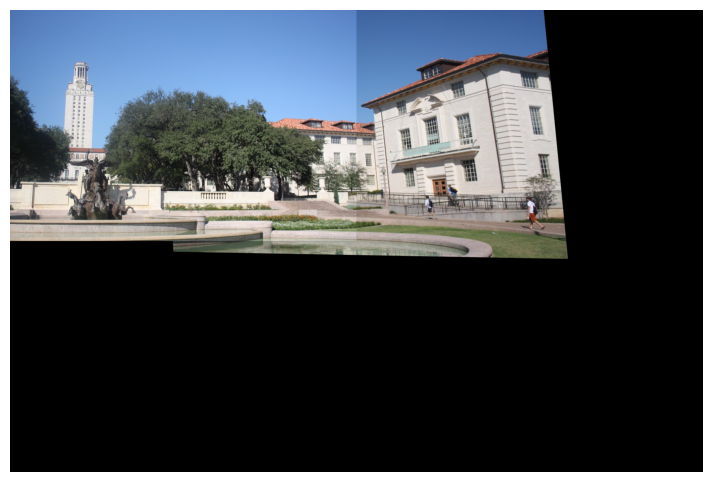

In [54]:
# Show image 
show_img(panorama_correction_sift())

> SURF algorithm

ERROR - OPENCV_ENABLE_NONFREE 

In [24]:
def matching_surf(img1, img2):
    # Starting the sift algorithm
    surf = cv2.xfeatures2d.SURF_create(400)

    key_points_1,descriptors_1 = surf.detectAndCompute(img1,None)
    key_points_2,descriptors_2 = surf.detectAndCompute(img2,None)

    # Starting Brute force matcher between the key_points 
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)


    matches = bf.match(descriptors_1,descriptors_2)

    matches = sorted(matches, key = lambda x:x.distance)
     
    # Drawing the matches points  
    final_img = cv2.drawMatches(img1,key_points_1,img2,key_points_2,matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return final_img

In [26]:
show_img(matching_surf(img_1, img_2))

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv_contrib\modules\xfeatures2d\src\surf.cpp:1029: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SURF::create'


> KAZE algorithm

In [59]:
def matching_kaze(img1, img2):
    # Initiate A-KAZE descriptor
    KAZE = cv2.KAZE_create()

    # Find the keypoints and compute the descriptors for input and training-set image
    keypoints1, descriptors1 = KAZE.detectAndCompute(img1, None)
    keypoints2, descriptors2 = KAZE.detectAndCompute(img2, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1

    index_params = dict(algorithm = FLANN_INDEX_KDTREE,
                        trees = 5)

    search_params = dict(checks = 50)

    # Convert to float32
    descriptors1 = np.float32(descriptors1)
    descriptors2 = np.float32(descriptors2)

    # Create FLANN object
    FLANN = cv2.FlannBasedMatcher(indexParams = index_params,
                                 searchParams = search_params)

    # Matching descriptor vectors using FLANN Matcher
    matches = FLANN.knnMatch(queryDescriptors = descriptors1,
                            trainDescriptors = descriptors2,
                            k = 2)

    # Lowe's ratio test
    ratio_thresh = 0.7

    # "Good" matches
    good_matches = []

    # Filter matches
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)



    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in keypoints1])
    kpsB = np.float32([kp.pt for kp in keypoints2])
    

    if len(good_matches) > 4:
   

        # estimate the homography between the sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in good_matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in good_matches])


        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,4)


        return (good_matches,H,status)

    else :
        return None 
    
    


In [60]:
def panorama_correction_kaze():
    M = matching_kaze(trainImg,queryImg)

    if M is None:
        print('ERROR')
        return None

    (matches,H,status) = M

    width =  trainImg.shape[1] + queryImg.shape[1]
    height = trainImg.shape[0] + queryImg.shape[0]

    result = cv2.warpPerspective(trainImg, H, (width, height))
    result[0:queryImg.shape[0], 0:queryImg.shape[1]]= queryImg

    return result


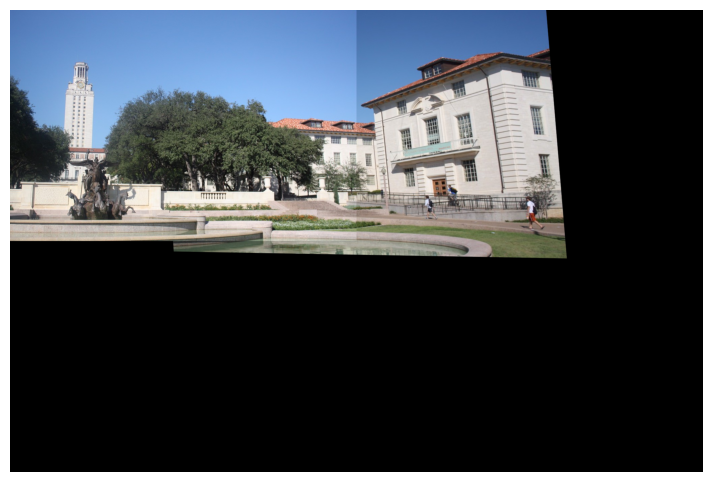

In [61]:
show_img(panorama_correction_kaze())

> AKAZE algorithm

In [65]:
def matching_akaze(img1, img2):
    # Initiate A-KAZE descriptor
    AKAZE = cv2.AKAZE_create()

    # Find the keypoints and compute the descriptors for input and training-set image
    keypoints1, descriptors1 = AKAZE.detectAndCompute(img1, None)
    keypoints2, descriptors2 = AKAZE.detectAndCompute(img2, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1

    index_params = dict(algorithm = FLANN_INDEX_KDTREE,
                        trees = 5)

    search_params = dict(checks = 50)

    # Convert to float32
    descriptors1 = np.float32(descriptors1)
    descriptors2 = np.float32(descriptors2)

    # Create FLANN object
    FLANN = cv2.FlannBasedMatcher(indexParams = index_params,
                                 searchParams = search_params)

    # Matching descriptor vectors using FLANN Matcher
    matches = FLANN.knnMatch(queryDescriptors = descriptors1,
                            trainDescriptors = descriptors2,
                            k = 2)

    # Lowe's ratio test
    ratio_thresh = 0.7

    # "Good" matches
    good_matches = []

    # Filter matches
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    
     # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in keypoints1])
    kpsB = np.float32([kp.pt for kp in keypoints2])
    
    
    if len(good_matches) > 4:
   

        # estimate the homography between the sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in good_matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in good_matches])


        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,4)


        return (good_matches,H,status)
   
    else:
        None
    



In [66]:
def panorama_correction_akaze():
    M = matching_akaze(trainImg,queryImg)

    if M is None:
        print('ERROR')
        return None

    (matches,H,status) = M

    width =  trainImg.shape[1] + queryImg.shape[1]
    height = trainImg.shape[0] + queryImg.shape[0]

    result = cv2.warpPerspective(trainImg, H, (width, height))
    result[0:queryImg.shape[0], 0:queryImg.shape[1]]= queryImg

    return result


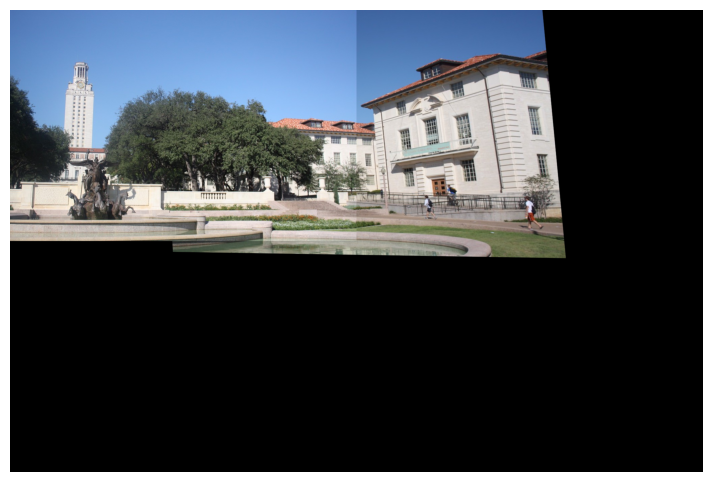

In [67]:
show_img(panorama_correction_akaze())

>  ORB algorithm

In [68]:
def matching_orb(img1, img2, nfeatures):
    # Starting the sift algorithm
    orb = cv2.ORB_create(nfeatures=nfeatures)

    key_points_1,descriptors_1 = orb.detectAndCompute(img1,None)
    key_points_2,descriptors_2 = orb.detectAndCompute(img2,None)

    # Starting Brute force matcher between the key_points 
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)


    matches = bf.match(descriptors_1,descriptors_2)

    matches = sorted(matches, key = lambda x:x.distance)
     
    
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in key_points_1])
    kpsB = np.float32([kp.pt for kp in key_points_2])

    if len(matches) > 4:
   

        # estimate the homography between the sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])


        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,4)


        return (matches,H,status)
   
    else:
        None
    


In [70]:
def panorama_correction_orb():
    M = matching_orb(trainImg,queryImg,10000)

    if M is None:
        print('ERROR')
        return None

    (matches,H,status) = M

    width =  trainImg.shape[1] + queryImg.shape[1]
    height = trainImg.shape[0] + queryImg.shape[0]

    result = cv2.warpPerspective(trainImg, H, (width, height))
    result[0:queryImg.shape[0], 0:queryImg.shape[1]]= queryImg

    return result


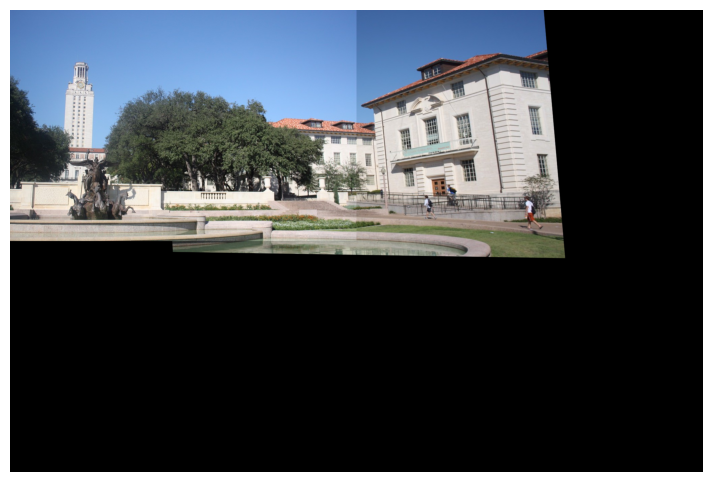

In [71]:
show_img(panorama_correction_orb())

> BRISK algorithm

In [72]:
def matching_brisk(img_1, img_2):
    BRISK = cv2.BRISK_create()

    # Find the keypoints and compute the descriptors for input and training-set image
    keypoints1, descriptors1 = BRISK.detectAndCompute(img_1, None)
    keypoints2, descriptors2 = BRISK.detectAndCompute(img_2, None)

    # create BFMatcher object
    BFMatcher = cv2.BFMatcher(normType = cv2.NORM_HAMMING,
                            crossCheck = True)

    # Matching descriptor vectors using Brute Force Matcher
    matches = BFMatcher.match(queryDescriptors = descriptors1,
                            trainDescriptors = descriptors2)

    # Sort them in the order of their distance
    matches = sorted(matches, key = lambda x: x.distance)


    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in keypoints1])
    kpsB = np.float32([kp.pt for kp in keypoints2])

    
    if len(matches) > 4:
   

        # estimate the homography between the sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])


        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,4)


        return (matches,H,status)
   
    else:
        None


In [73]:
def panorama_correction_brisk():
    M = matching_brisk(trainImg,queryImg)

    if M is None:
        print('ERROR')
        return None

    (matches,H,status) = M

    width =  trainImg.shape[1] + queryImg.shape[1]
    height = trainImg.shape[0] + queryImg.shape[0]

    result = cv2.warpPerspective(trainImg, H, (width, height))
    result[0:queryImg.shape[0], 0:queryImg.shape[1]]= queryImg

    return result


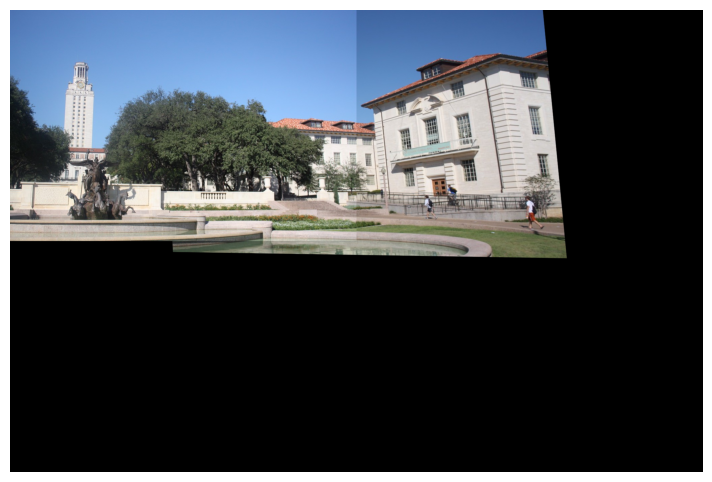

In [74]:
show_img(panorama_correction_brisk())